# MELD Dataset Exploration and Wrangling

In this notebook I prepare and wrangle the MELD training data for the purpose of emotion classification.

I first got a sense of the tabular labeled CSV data. I listened to the outlier short and long utterances which lead me to remove to unintelligle short utterances. I noted that 6 speakers comprise 83% of the data and the presence of a 17x class imbalance b/w fear and neutral and b/w digust and neutral.

I then investigated the following feature extraction methods: Mel-scaled spectrogram,
Mel-frequency cepstral coefficients, Chroma. 
The features produced by these methods are individually weakly correlated with the DV, emotion. Each of the three sets of features can be reduced using PCA and still capture a significant portion of the data's characteristics. This would be especially useful for reducing the 128 melspectrogram features down to ~50 to reduce model complexity.


I determined that PCA should be able to help reduce the number of features. Also that 5 seconds should be enough time to make an accurate judgment of emotion. Training on the males, females, or the entire dataset does not yield much different performance. There are slight performance different when training on single characters, in terms of F1 score on the dev set and the Silhouette Score on the train set, however theses differences do not appear to warrant special treatment.

In [1]:
import os
import pickle
import sys
from random import sample
from shutil import rmtree
from tempfile import mkdtemp
from time import time

from IPython.display import Audio, display
import librosa
from librosa.display import waveplot
import moviepy.editor as mp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets, preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale, StandardScaler
from tqdm.notebook import tqdm_notebook

N.B. librosa -> numba -> numpy==1.2.0 which is available for python-3.7

## Training Data

The emotion labels I am interested in are stored in CSV with each item uniquely ID'd by Dialogue_ID and Utterance_ID.  The raw audio will be obtained later from MP4 video files.

In [2]:
train_df = pd.read_csv('data/train_labels.csv')
train_df.head(2)

Sr No.                                          Utterance          Speaker  \
0       1  also I was the point person on my companys tr...         Chandler   
1       2                   You mustve had your hands full.  The Interviewer   

   Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode  \
0  neutral   neutral            0             0       8       21   
1  neutral   neutral            0             1       8       21   

      StartTime       EndTime  
0  00:16:16,059  00:16:21,731  
1  00:16:21,940  00:16:23,442

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9989 entries, 0 to 9988
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        9989 non-null   int64 
 1   Utterance     9989 non-null   object
 2   Speaker       9989 non-null   object
 3   Emotion       9989 non-null   object
 4   Sentiment     9989 non-null   object
 5   Dialogue_ID   9989 non-null   int64 
 6   Utterance_ID  9989 non-null   int64 
 7   Season        9989 non-null   int64 
 8   Episode       9989 non-null   int64 
 9   StartTime     9989 non-null   object
 10  EndTime       9989 non-null   object
dtypes: int64(5), object(6)
memory usage: 858.6+ KB


## Dev (CV) Data

In [4]:
dev_df = pd.read_csv('data/dev_labels.csv')
dev_df.head(2)

Sr No.                                       Utterance Speaker   Emotion  \
0       1  Oh my God, hes lost it. Hes totally lost it.  Phoebe   sadness   
1       2                                           What?  Monica  surprise   

  Sentiment  Dialogue_ID  Utterance_ID  Season  Episode     StartTime  \
0  negative            0             0       4        7  00:20:57,256   
1  negative            0             1       4        7  00:21:01,927   

        EndTime  
0  00:21:00,049  
1  00:21:03,261

In [5]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        1109 non-null   int64 
 1   Utterance     1109 non-null   object
 2   Speaker       1109 non-null   object
 3   Emotion       1109 non-null   object
 4   Sentiment     1109 non-null   object
 5   Dialogue_ID   1109 non-null   int64 
 6   Utterance_ID  1109 non-null   int64 
 7   Season        1109 non-null   int64 
 8   Episode       1109 non-null   int64 
 9   StartTime     1109 non-null   object
 10  EndTime       1109 non-null   object
dtypes: int64(5), object(6)
memory usage: 95.4+ KB


## Test Data

In [6]:
test_df = pd.read_csv('data/test_labels.csv')
test_df.head(5)

Sr No.                                          Utterance Speaker  \
0       1  Why do all youre coffee mugs have numbers on ...    Mark   
1       2  Oh. Thats so Monica can keep track. That way ...  Rachel   
2       3                                       Y'know what?  Rachel   
3      19                     Come on, Lydia, you can do it.    Joey   
4      20                                              Push!    Joey   

    Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode  \
0  surprise  positive            0             0       3       19   
1     anger  negative            0             1       3       19   
2   neutral   neutral            0             2       3       19   
3   neutral   neutral            1             0       1       23   
4       joy  positive            1             1       1       23   

      StartTime       EndTime  
0  00:14:38,127  00:14:40,378  
1  00:14:40,629  00:14:47,385  
2  00:14:56,353  00:14:57,520  
3   0:10:44,769   0:10:46,146  
4   0:10:46,146   0:10:46,833

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        2610 non-null   int64 
 1   Utterance     2610 non-null   object
 2   Speaker       2610 non-null   object
 3   Emotion       2610 non-null   object
 4   Sentiment     2610 non-null   object
 5   Dialogue_ID   2610 non-null   int64 
 6   Utterance_ID  2610 non-null   int64 
 7   Season        2610 non-null   int64 
 8   Episode       2610 non-null   int64 
 9   StartTime     2610 non-null   object
 10  EndTime       2610 non-null   object
dtypes: int64(5), object(6)
memory usage: 224.4+ KB


## Label-audio mapping
 
Note that the 3 dataframes have overlapping / non-unique dialog-utterance ids. So until I am able to load the audio into the dataframes, I should not try to join them!

## Data Wrangling and Exploration

### Missing Values

In [8]:
def df_missing_any(df) -> bool:
    # isna: NaN in numeric arrays, None or NaN in object arrays, NaT in datetimelike
    return df.isna().values.any()

assert not df_missing_any(train_df)
assert not df_missing_any(dev_df)
assert not df_missing_any(test_df)

### Construct unique id 

In [9]:
def add_dia_utt(dataframe):
    # feature vectors and audtio files are stored by 'dia_utt' so create that in the df
    cols = ['Dialogue_ID', 'Utterance_ID']
    dataframe['dia_utt'] = dataframe[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)


datasets = (train_df, dev_df, test_df)
for df in datasets:
    add_dia_utt(df)
    print(df['dia_utt'])
    assert df['dia_utt'].is_unique

0           0_0
1           0_1
2           0_2
3           0_3
4           0_4
         ...   
9984    1038_13
9985    1038_14
9986    1038_15
9987    1038_16
9988    1038_17
Name: dia_utt, Length: 9989, dtype: object
0          0_0
1          0_1
2          1_0
3          1_1
4          1_2
         ...  
1104     113_9
1105    113_10
1106    113_11
1107    113_12
1108    113_13
Name: dia_utt, Length: 1109, dtype: object
0          0_0
1          0_1
2          0_2
3          1_0
4          1_1
         ...  
2605    279_11
2606    279_12
2607    279_13
2608    279_14
2609    279_15
Name: dia_utt, Length: 2610, dtype: object


### Column-wise Exploration

#### Utterance

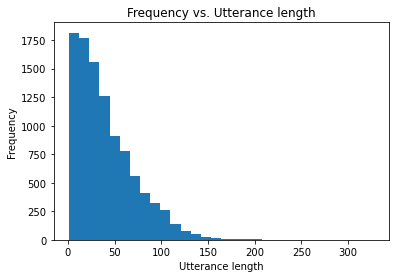

In [13]:
train_df['Utterance_len'] = train_df['Utterance'].apply(len)
plt.hist(train_df.Utterance_len, bins=30)
plt.title('Frequency vs. Utterance length')
plt.ylabel('Frequency')
plt.xlabel('Utterance length');

In [14]:
train_df.Utterance_len.describe()

count    9989.000000
mean       40.528381
std        31.953528
min         1.000000
25%        16.000000
50%        32.000000
75%        58.000000
max       327.000000
Name: Utterance_len, dtype: float64

Most of the utterances are short, but there are some long ones too. Next I will take a close look at the short utterances.

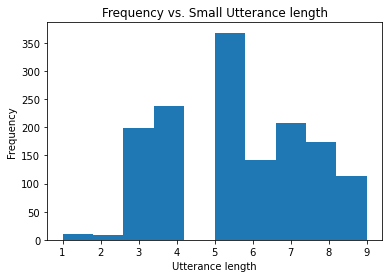

In [15]:
plt.hist(train_df.Utterance_len[train_df.Utterance_len < 10])
plt.title('Frequency vs. Small Utterance length')
plt.ylabel('Frequency')
plt.xlabel('Utterance length');

These must be one word utterances. 

In [16]:
train_df.Utterance[train_df.Utterance_len < 3].value_counts()
# Check out the outlier short utterances

I     10
No     2
Is     1
Wh     1
!      1
We     1
Hi     1
Eh     1
In     1
It     1
Name: Utterance, dtype: int64

Ok, some of these are sensible one-word uttearnces, but some may be "junk."

I want to hear these outlier small utterances to determine whether they should be included. 

In [17]:
short_audio_paths = []
for i, id in train_df.dia_utt[train_df.Utterance_len < 3].iteritems():
    path = 'data/audio/train/' + id + '.wav'
    short_audio_paths.append(os.path.join(os.getcwd(), path))
    
print(len(short_audio_paths))

20


In [18]:
def display_audio_from(path: str):
    audio, sr = librosa.load(fp)
    Audio(audio, rate=sr)

    
for sap in short_audio_paths:
    print(sap)
    try:
        audio, sr = librosa.load(sap)
        display(Audio(audio, rate=sr))
    except Exception as e: 
        print(e)

/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/29_9.wav


/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/30_8.wav


/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/126_3.wav


/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/138_9.wav


/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/254_4.wav


/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/272_6.wav


/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/351_11.wav
[Errno 2] No such file or directory: '/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/351_11.wav'
/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/369_0.wav


/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/395_7.wav


/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/430_8.wav
[Errno 2] No such file or directory: '/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/430_8.wav'
/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/435_0.wav


/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/478_11.wav


/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/583_9.wav


/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/588_6.wav


/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/599_16.wav


/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/617_9.wav


/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/645_12.wav


/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/663_7.wav


/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/873_3.wav


/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/897_6.wav


These utterances are unintelligble to me:
    
- 351_11.wav 
- 430_8.wav 

Given their labels below, I think it is best to remove them.

In [19]:
train_df[train_df.dia_utt == '351_11']

Sr No. Utterance Speaker Emotion Sentiment  Dialogue_ID  Utterance_ID  \
3339    3527        Wh    Mona     joy  positive          351            11   

      Season  Episode    StartTime      EndTime dia_utt  Utterance_len  
3339       8        8  0:12:06,480  0:12:06,732  351_11              2

In [20]:
train_df[train_df.dia_utt == '430_8']

Sr No. Utterance Speaker Emotion Sentiment  Dialogue_ID  Utterance_ID  \
3991    4209        No    Joey   anger  negative          430             8   

      Season  Episode     StartTime       EndTime dia_utt  Utterance_len  
3991       6        2  00:02:16,553  00:02:18,011   430_8              2

In [21]:
print(train_df.shape)
train_df.drop(train_df[train_df.dia_utt == '351_11'].index, inplace=True)
train_df.drop(train_df[train_df.dia_utt == '430_8'].index, inplace=True)
print(train_df.shape)

(9989, 13)
(9987, 13)


Next I want to look at the utterances with outlier length.

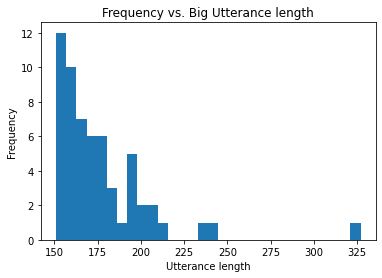

In [22]:
plt.hist(train_df.Utterance_len[train_df.Utterance_len > 150], bins=30)
plt.title('Frequency vs. Big Utterance length')
plt.ylabel('Frequency')
plt.xlabel('Utterance length');

Looks like there are some longer dialogues thay may have to be split in smaller chunks or only evaluate a prefix.

Make the few lenghty outliers audible...

In [23]:
for i, id in train_df.dia_utt[train_df.Utterance_len > 200].iteritems():
    path = 'data/audio/train/' + id + '.wav'
    path = os.path.join(os.getcwd(), path)
    
    audio, sr = librosa.load(path)
    print('\n', path)
    display(Audio(audio, rate=sr))


 /Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/152_11.wav



 /Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/383_1.wav



 /Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/455_11.wav



 /Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/510_0.wav



 /Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/644_5.wav



 /Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/647_0.wav



 /Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks/data/audio/train/757_2.wav


Listening to these longer clips, I judge that the overall emotion is stable, there's just a long dialogue. However, these make me realize that there are often unedited 'laugh tracks' included in the utterances which surely will influence the results. The laugh tracks usually come in towards the end of the utterance, so I suspect that focusing on the earlier part of the utterance will reduce their influence. Perhaps for a given utterance I could perform class inference multiple times on different segments of longer utterances.

#### Speaker column exploration

In [24]:
speaker_counts = train_df['Speaker'].value_counts()
speaker_counts

Joey                1508
Ross                1459
Rachel              1435
Phoebe              1321
Monica              1299
                    ... 
Phoebe/Waitress        1
Vince                  1
Gary Collins           1
Hold Voice             1
Front Desk Clerk       1
Name: Speaker, Length: 260, dtype: int64

In [25]:
top_speakers = speaker_counts[speaker_counts > 100]
top_speakers

Joey        1508
Ross        1459
Rachel      1435
Phoebe      1321
Monica      1299
Chandler    1283
Name: Speaker, dtype: int64

In [26]:
round(100 * sum(top_speakers) / sum(speaker_counts), 2)

83.16

83 % of the data comes from the 6 main characters. I could limit the training set to utterance only from these six characters or even only 1 of the characters and determine performance for that data subset.

#### Emotion column exploration

Emotion is the main DV I wish to predict

In [27]:
emo_cnts = train_df['Emotion'].value_counts(normalize=True)
emo_cnts * 100

neutral     47.161310
joy         17.442675
surprise    12.065685
anger       11.094423
sadness      6.838891
disgust      2.713528
fear         2.683489
Name: Emotion, dtype: float64

Highlight the class imbalance by normalizing on largest class

In [28]:
emo_cnts.neutral / emo_cnts 

neutral      1.000000
joy          2.703789
surprise     3.908714
anger        4.250903
sadness      6.896047
disgust     17.380074
fear        17.574627
Name: Emotion, dtype: float64

The emotion classes are somewhat imbalanced. Neutral is overrepresented, while sadness, disgust, and fear are underrepresented. For instance, neutral occurs 17x more than digust and fear.  "Most of the contemporary works in class imbalance concentrate on imbalance ratios
 ranging from 1:4 up to 1:100" (https://link.springer.com/article/10.1007/s13748-016-0094-0 )

Some ideas to consider to address: 

- over-sampling underrepresented classes since dataset size is on the smaller end
- using random and non-random (e.g. stratified) sampling schemes
- using tree-based menthods which often perform well on imbalanced datasets
- using regularization to avoid overfitting
- combining the negative emotions into 1 group to simplify the problem and increase the data per class

#### Sentiment column exploration



In [29]:
sent_counts = train_df['Sentiment'].value_counts(normalize=True)
sent_counts

neutral     0.471613
negative    0.294783
positive    0.233604
Name: Sentiment, dtype: float64

The sentiment classes are fairly balanced, 
i.e. difference b/w neutral and positive is 2x 

#### Dialogue_ID

In [30]:
dialog_counts = train_df['Dialogue_ID'].value_counts(sort=True)
print('total dialogs ', len(dialog_counts))
print(dialog_counts)

total dialogs  1038
523    24
54     24
450    24
649    24
530    24
       ..
987     1
790     1
581     1
490     1
742     1
Name: Dialogue_ID, Length: 1038, dtype: int64


Utterance distribution across dialogues is reasonable. Most occurrences is 24 out of 1038 for some dialogs.

#### Utterance_ID

Based on Dialog id counts this should range from 0-23

In [31]:
train_df['Utterance_ID'].value_counts()

0     1028
1      965
2      899
3      848
4      803
5      733
6      676
7      603
8      535
9      483
10     433
11     377
12     322
13     282
14     246
15     215
16     157
17     123
18      93
19      69
20      48
21      30
22      14
23       5
Name: Utterance_ID, dtype: int64

#### Season

In [32]:
train_df['Season'].value_counts().sort_index()

1    1402
2     289
3    1609
4    1129
5    1265
6    1316
7    1380
8    1107
9     490
Name: Season, dtype: int64

Seasons 2, 9 are slightly underrepresented but this shouldn't have an effect.

#### Episode

In [33]:
train_df['Episode'].value_counts().sort_index()

1     396
2     468
3     368
4     440
5     630
6     417
7     364
8     217
9     294
10    456
11    440
12    586
13    334
14    429
15    365
16    259
17    410
18    388
19    355
20    361
21    398
22    392
23    686
24    381
25    153
Name: Episode, dtype: int64

Summary of labels and metdata exploration

- there are some outlier utterance in terms of length, small and large
- 6 speakers comprise 83% of the data
- 17x class imbalance b/w fear and neutral and b/w digust and neutral

### Encode Labels

__Must convert the emotion labels to numeric. Use ordinal encoding__


In [34]:
label_encoder = preprocessing.LabelEncoder()

for df in datasets:
    df['emotion_class'] = label_encoder.fit_transform(df['Emotion'])
    print(df[['Emotion', 'emotion_class']].head(), '\n')

    Emotion  emotion_class
0   neutral              4
1   neutral              4
2   neutral              4
3   neutral              4
4  surprise              6 

    Emotion  emotion_class
0   sadness              5
1  surprise              6
2   neutral              4
3       joy              3
4   sadness              5 

    Emotion  emotion_class
0  surprise              6
1     anger              0
2   neutral              4
3   neutral              4
4       joy              3 



# Audio File Wrangling and Exploration

#### Convert mp4 to mp3

In [35]:
def convert_mp4_to_wav(path: str):
    finished = set(f.split('.')[0] for f in os.listdir(path) if f.split('.')[1] == 'wav')
    print('already finished: ', len(finished))

    fails = []
    mp4_paths = [os.path.join(path, f) for f in os.listdir(path) if f.split('.')[1] == 'mp4']
    for mp4_path in mp4_paths:
        fname = mp4_path.split('/')[-1].split('.')[0]
        fname = fname.replace('dia', '').replace('utt', '').replace('final_videos_test', '')
        if fname in finished:
            continue

        try:
            clip = mp.VideoFileClip(mp4_path)

            # pick highest quality kwargs based on https://zulko.github.io/moviepy/ref/AudioClip.html
            out_path = os.path.join(path, fname + '.wav')
            clip.audio.write_audiofile(out_path, nbytes=4, codec='pcm_s32le', bitrate='3000k')
        except Exception as e:
            fails.append(e) 

    print(f'Finished with {len(fails)} failure(s): {fails}')
    

In [362]:
convert_mp4_to_wav('data/audio/train')

already finished:  9986
Finished with 0 failure(s): []


In [363]:
convert_mp4_to_wav('data/audio/dev')

already finished:  1112
Finished with 0 failure(s): []


In [364]:
convert_mp4_to_wav('data/audio/test')

already finished:  2747
Finished with 0 failure(s): []


In [36]:
train_path = 'data/audio/train'
train_wav_paths = [os.path.join(train_path, fname) for fname in os.listdir(train_path)]
train_wav_paths.sort()
print(len(train_wav_paths))
print(train_wav_paths[:3])

9986
['data/audio/train/0_0.wav', 'data/audio/train/0_1.wav', 'data/audio/train/0_10.wav']


In [37]:
dev_path = 'data/audio/dev'
dev_wav_paths = [os.path.join(dev_path, fname) for fname in os.listdir(dev_path)]
print(len(dev_wav_paths))
print(dev_wav_paths[:3])

1112
['data/audio/dev/104_5.wav', 'data/audio/dev/90_3.wav', 'data/audio/dev/56_5.wav']


In [38]:
test_path = 'data/audio/test'
test_wav_paths = [os.path.join(test_path, fname) for fname in os.listdir(test_path)]
print(len(test_wav_paths))
print(test_wav_paths[:3])

2747
['data/audio/test/112_12.wav', 'data/audio/test/268_9.wav', 'data/audio/test/218_0.wav']


In [39]:
def add_audio(df: pd.DataFrame, audio_path: str):
    """For each row in given DataFrame, load corresponding audio 
    and add it to the DataFrame. This avoids checkpointing problems
    later since the audio files have their own naming convention. 
    Also, later features can be associated to the ordered labels.
    """
    audios, srs = [], []
    for uid in df['dia_utt']:
        path = os.path.join(audio_path, uid) + '.wav'
        if os.path.exists(path):
            audio, sr = librosa.load(path)
        else:
            audio = []
            sr = 0
            print('Missing: ', path)
            
        audios.append(audio)
        srs.append(sr)
    
    df['audio'] = audios
    df['sr'] = srs

In [40]:
%%time
add_audio(train_df, 'data/audio/train')
train_df[['dia_utt', 'sr', 'audio']].head(3)

Missing:  data/audio/train/125_3.wav
CPU times: user 16min 52s, sys: 16.1 s, total: 17min 8s
Wall time: 17min 46s


dia_utt     sr                                              audio
0     0_0  22050  [-0.0018416838, -0.021530326, -0.025807647, 0....
1     0_1  22050  [0.00043347786, -0.0010333004, -0.004485007, -...
2     0_2  22050  [-0.0008792415, -0.0013375154, -0.0016431048, ...

Worth noting that the sample rate is 22050 which is exactly half of the typical 44100 or 44.1Khz.

In [41]:
train_df.drop(train_df[train_df.dia_utt == '125_3'].index, inplace=True)
train_df.shape

(9986, 16)

In [42]:
add_audio(dev_df, 'data/audio/dev')

Missing:  data/audio/dev/110_7.wav


In [43]:
dev_df.drop(dev_df[dev_df.dia_utt == '110_7'].index, inplace=True)
print(dev_df.shape)

(1108, 15)


In [44]:
add_audio(test_df, 'data/audio/test')

In [45]:
test_df.shape

(2610, 15)

## EDA of audio files

Text(0.5, 0, 'seconds')

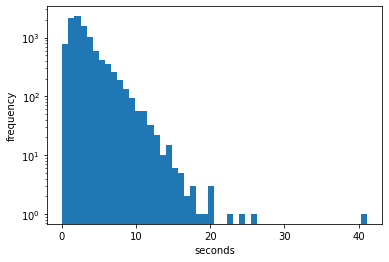

In [46]:
train_df['audio_len'] = train_df['audio'].apply(len) / train_df['sr']
plt.hist(train_df['audio_len'], bins=50)
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.xlabel('seconds')

In [47]:
train_df['audio_len'].describe()

count    9986.000000
mean        3.155314
std         2.428357
min         0.080000
25%         1.570023
50%         2.480000
75%         3.940000
max        41.060000
Name: audio_len, dtype: float64

Check if the audio durations mentioned in the CSV match the actual audio lenghts.

In [48]:
from datetime import datetime

dt_format = '%H:%M:%S,%f'
def to_dt(df):
    return pd.to_datetime(df, infer_datetime_format=True)

label_elapsed = to_dt(train_df['EndTime']) - to_dt(train_df['StartTime'])
label_elapsed /= np.timedelta64(1, 's')
(label_elapsed - train_df.audio_len).describe()

count    9986.000000
mean       -0.016498
std         0.088936
min        -2.514000
25%        -0.024023
50%        -0.021000
75%        -0.018000
max         8.444000
dtype: float64

There are clearly some descrepencies, but it's not a big deal.

## Data drift

Does audio length change as time goes on?

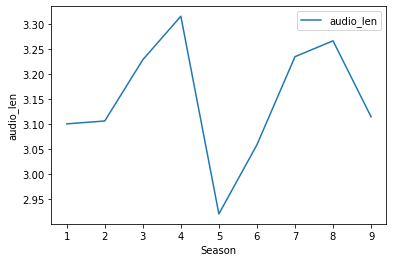

In [49]:
train_df.groupby(['Season']).mean()[['audio_len']].plot(ylabel='audio_len');

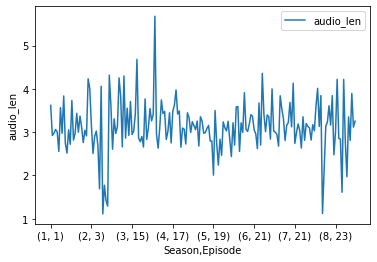

In [50]:
train_df.groupby(['Season', 'Episode']).mean()[['audio_len']].plot(ylabel='audio_len');

Audio length appears quite stable over seasons and seasons-episodes. What about Emotion, which I want to predict?

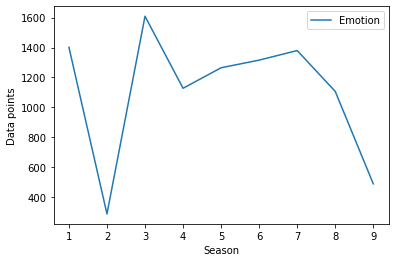

In [51]:
samples_per_season = train_df.groupby(['Season']).count()[['Emotion']]
samples_per_season.plot(ylabel='Data points');

Here we have the total number of utterances for each season, next I'll plot the proportion of the utterances labeled with each emotion.

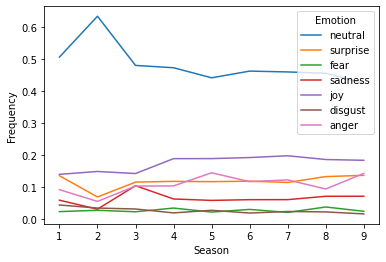

<Figure size 4800x3200 with 0 Axes>

In [53]:
for emotion in train_df.Emotion.unique():
    emo_by_season = train_df[train_df.Emotion == emotion].groupby(['Season']).count()[['Emotion']]
    plt.plot(emo_by_season / samples_per_season, label=emotion)

matplotlib.rcParams.update({'font.size': 10})
plt.ylabel('Frequency')
plt.xlabel('Season')
plt.legend(title='Emotion')
plt.figure(figsize=(24, 16), dpi=200)
plt.show();

Looks like neutral utterances decrease over time. Joy and anger slightly increase over time. The degree does not appear significant to cause strong concerns about needing to retrain the model on more frequent data.

## Feature Extraction

### Mel-scaled spectrogram

- time-frequency representation of sound
- sampled into a number of points around equally spaced times and frequencies on a Mel frequency scale
- Mel frequency scale: mel = 2595 * log10 (1 + hertz / 700)
- constructed such that sounds of equal distance from each other on the Mel Scale, also sound to humans as they are equal distance from on another
- in contrast to Hz scale where 500-1000 hz is obvious but 7500 to 8000 barely noticeable


Explore feature extraction for a simple sample...

In [54]:
dia_utt, y, sr, label = train_df[['dia_utt', 'audio', 'sr', 'emotion_class']].head(1).values[0]
print('id ', dia_utt, '\nsize ', len(y), '\nlabel ', label)

id  0_0 
size  125465 
label  4


In [55]:
display(Audio(y, rate=sr))

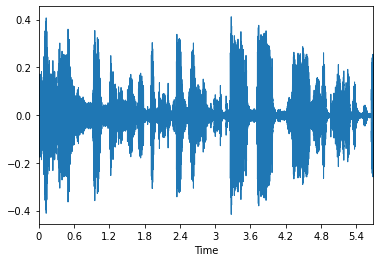

In [56]:
waveplot(y, sr=sr);

Apply FFT

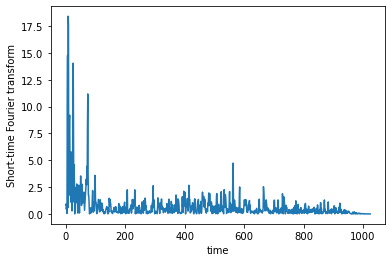

In [57]:
n_fft = 2048
D = np.abs(librosa.stft(y[:n_fft], n_fft=n_fft, hop_length=n_fft + 1))
plt.plot(D)
plt.ylabel('Short-time Fourier transform')
plt.xlabel('time');

FFT + time windows

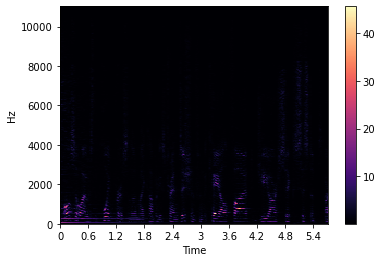

In [58]:
hop_length = 512
D = np.abs(librosa.stft(y, n_fft=n_fft,  hop_length=hop_length))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear');
plt.colorbar();

Time windows transformed to DB scale

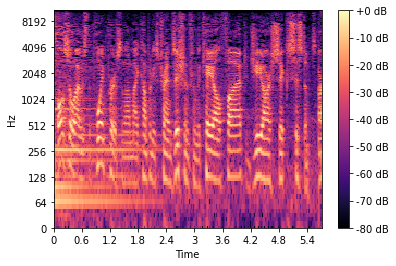

In [59]:
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

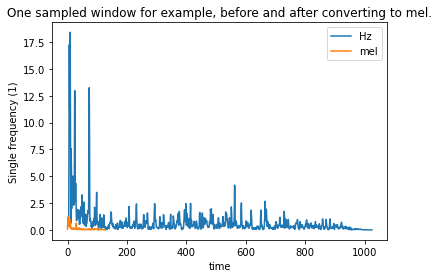

In [60]:
n_mels = 128
mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)

plt.plot(D[:, 1])
plt.plot(mel.dot(D[:, 1]))
plt.legend(labels=['Hz', 'mel'])
plt.title('One sampled window for example, before and after converting to mel.')
plt.xlabel('time')
plt.ylabel('Single frequency (1)');

Create melspectrogram of 128 features for each time window

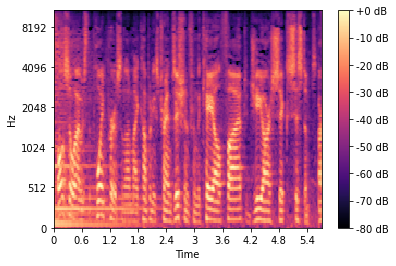

In [61]:
S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_db = librosa.power_to_db(S, ref=np.max)

librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB');

#### Melspectrogram Recap
- Separate to windows: Sample the input with windows of size n_fft=2048, making hops of size hop_length=512 each time to sample the next window.
- Compute FFT (Fast Fourier Transform) for each window to transform from time domain to frequency domain.
- Generate a Mel scale: Take the entire frequency spectrum, and separate it into n_mels=128 evenly spaced frequencies.
- And what do we mean by evenly spaced? not by distance on the frequency dimension, but distance as it is heard by the human ear.
- Generate Spectrogram: For each window, decompose the magnitude of the signal into its components, corresponding to the frequencies in the mel scale.

Sources: 
- https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
- https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53

### Mel-frequency cepstral coefficients (MFCCs)

- representation of the short-term power spectrum of a sound based on a linear cosine transform of a log power spectrum on a mel scale of frequency
- Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC.[1] They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal spectrum. This frequency warping can allow for better representation of sound, for example, in audio compression
(https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)

- small set of features (usually 10-20) which concisely describe the overall shape of a spectral envelope

In [62]:
mfccs = librosa.feature.mfcc(y, sr=sr)
print('{} MFCCs over {} frames'.format(*mfccs.shape))

20 MFCCs over 246 frames


The very first MFCC, the 0th coefficient, does not convey information relevant to the overall shape of the spectrum. It only conveys a constant offset, i.e. adding a constant value to the entire spectrum. Therefore, many practitioners will discard the first MFCC when performing classification. For now, we will use the MFCCs as is.
(source: https://musicinformationretrieval.com/mfcc.html)

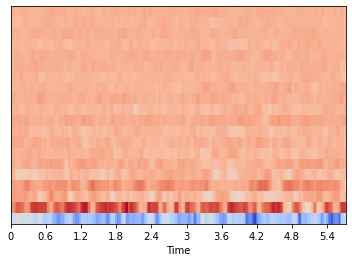

In [63]:
librosa.display.specshow(mfccs, sr=sr, x_axis='time');

Apply feature scaling to mean 0 and variance 1

In [64]:
mfccs = scale(mfccs, axis=1)

print(mfccs.mean(axis=1))  # close to 0
print(mfccs.var(axis=1))  # close to 1

[ 0.0000000e+00  0.0000000e+00 -7.7534494e-09  2.9075435e-09
  0.0000000e+00 -7.7534494e-09  7.7534494e-09 -1.9383624e-09
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -7.7534494e-09
  0.0000000e+00  1.1630174e-08  0.0000000e+00 -1.1630174e-08
  3.8767247e-09 -7.7534494e-09 -7.7534494e-09  1.1630174e-08]
[1.         1.0000001  0.99999994 1.0000001  1.         1.0000001
 1.0000001  1.0000001  0.99999994 0.99999994 1.         0.9999999
 1.0000001  1.         1.         1.         1.0000001  1.0000002
 0.99999994 1.0000001 ]


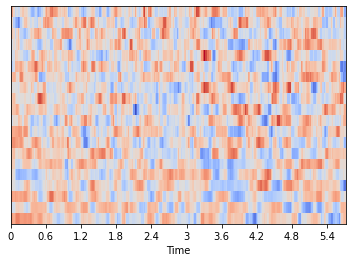

In [65]:
librosa.display.specshow(mfccs, sr=sr, x_axis='time');

### Chroma

A chroma vector (Wikipedia) (FMP, p. 123) is a typically a 12-element feature vector indicating how much energy of each pitch class, {C, C#, D, D#, E, ..., B}, is present in the signal.

Code snippets:
- http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/generated/librosa.feature.chroma_stft.html
- https://musicinformationretrieval.com/chroma.html

In [66]:
def plot_chroma(chroma, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()

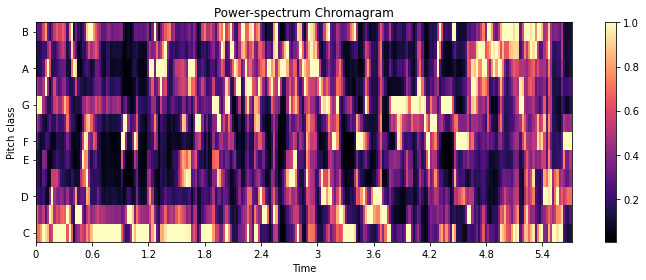

In [67]:
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

plot_chroma(chroma, 'Power-spectrum Chromagram')

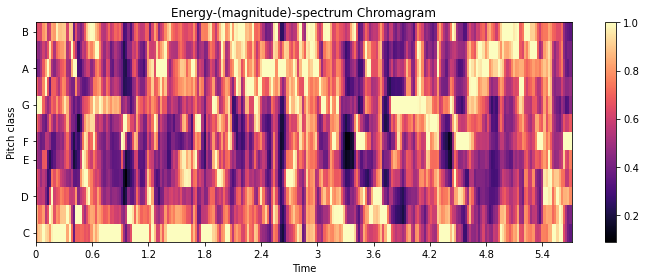

In [68]:
S = np.abs(librosa.stft(y))
chroma = librosa.feature.chroma_stft(S=S, sr=sr)
title = 'Energy-(magnitude)-spectrum Chromagram'

plot_chroma(chroma, title)

### Sklearn Pipeline

I want to cross validate various hyperparameters in the following ML pipeline:

signal -> trim and extract-features -> standardize -> PCA -> estimator -> prediction

I will use sklearn Pipeline and define several Transformers for the processing steps.

Create an sklearn Transformer for the feature extraction. 

In [69]:
from sklearn.base import BaseEstimator, TransformerMixin


class ExtractTransformer(BaseEstimator, TransformerMixin):
    """Trims signal removing all data beyond given limit, then extracts specified features."""

    def __init__(self, sr: int, limit: int = None, mel=True, mfcc=True, n_mfcc: int = 20, chroma=True):
        self.sr = sr
        self.limit = limit
        self.mel = mel
        self.mfcc = mfcc
        self.n_mfcc = n_mfcc
        self.chroma = chroma

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        result = []
#         for r in tqdm_notebook(X, desc=f'Extract with limit={limit}: '):
# ^^ this fails to pickle when I create an sklearn Pipeline with memory 
        for r in X:
            row = r[:self.limit] if self.limit else r
            feature_groups = []
            if self.mel:
                feature_groups.append(self.extract_melspectrogram(row))
            if self.mfcc:
                feature_groups.append(self.extract_mfcc(row))
            if self.chroma:
                feature_groups.append(self.extract_chroma(row))
            result.append(np.hstack(feature_groups))

        return np.array(result)

    def extract_melspectrogram(self, X):
        return np.mean(librosa.feature.melspectrogram(X, sr=self.sr).T, axis=0)

    def extract_mfcc(self, X):
        return np.mean(librosa.feature.mfcc(y=X, sr=self.sr, n_mfcc=self.n_mfcc).T, axis=0)

    def extract_chroma(self, X):
        stft = np.abs(librosa.stft(X))
        return np.mean(librosa.feature.chroma_stft(S=stft, sr=self.sr).T, axis=0)


In [65]:
# GridSearchCV was throwing an exception saying it couldn't pickle this class?!
with open('test_transformer.pickle', 'wb') as f:
    pickle.dump(ExtractTransformer(sr), f)

In [27]:
limit = 50000
sample = train_df.audio.values[:10]
ExtractTransformer(limit, sr, mel=True, mfcc=False, chroma=False).transform(sample).shape

Extract with limit=50000:   0%|          | 0/10 [00:00<?, ?it/s]

(10, 128)

In [28]:
ExtractTransformer(limit, sr, mel=False, mfcc=True, n_mfcc=20, chroma=False).transform(sample).shape

Extract with limit=50000:   0%|          | 0/10 [00:00<?, ?it/s]

(10, 20)

In [29]:
ExtractTransformer(limit, sr, mel=False, mfcc=False, chroma=True).transform(sample).shape

Extract with limit=50000:   0%|          | 0/10 [00:00<?, ?it/s]

(10, 12)

In [30]:
ExtractTransformer(limit, sr).transform(sample).shape

Extract with limit=50000:   0%|          | 0/10 [00:00<?, ?it/s]

(10, 160)

## Extracting Features from Audio

While I can cross validate with different audio length, it will also be useful to compute the features for the full length audio one time and avoid the time cost of recomputing them.

In [70]:
for ds in datasets:
    tmp = max(ds.audio.apply(len))
    assert 1e7 > tmp


10 MM upper bounds all the audios

In [71]:
limit = int(1e10)
transformer = ExtractTransformer(limit, sr)

X_train = transformer.transform(train_df.audio.values)

In [1004]:
X_dev = transformer.transform(dev_df.audio.values)
X_test = transformer.transform(test_df.audio.values)

assert not np.isnan(sum(X_train.ravel()))
assert not np.isnan(sum(X_dev.ravel()))
assert not np.isnan(sum(X_test.ravel()))

Extract progress:   0%|          | 0/1108 [00:00<?, ?it/s]

Extract progress:   0%|          | 0/2610 [00:00<?, ?it/s]

In [1007]:
y_train = train_df['emotion_class']
y_dev = dev_df['emotion_class']
y_test = test_df['emotion_class']

In [1008]:
print(X_train.shape, y_train.shape)
print(X_dev.shape, y_dev.shape)
print(X_test.shape, y_test.shape)

(9986, 160) (9986,)
(1108, 160) (1108,)
(2610, 160) (2610,)


Add the extracted features back into the dataframes to facilitate easy selection of data subsets.

In [1017]:
# combine_first() perfroms an upsert at the value level into target
train_df = train_df.combine_first(pd.DataFrame(X_train))
print(train_df.columns.values)
print(train_df[[1, 2, 3]].head(2))

dev_df = dev_df.combine_first(pd.DataFrame(X_dev))  
print()
print(dev_df.columns.values)

test_df = test_df.combine_first(pd.DataFrame(X_test))
print()
print(test_df.columns.values)

[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 'Dialogue_ID' 'Emotion' 'EndTime' 'Episode'
 'Season' 'Sentiment' 'Speaker' 'Sr No.' 'StartTime' 'Utterance'
 'Utterance_ID' 'Utterance_len' 'audio' 'audio_len' 'dia_utt'
 'emotion_class' 'sr']
          1         2         3
0  0.763453  1.154009  1.324336
1  0.047854  0.517326  5.467506

[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 5

In [1029]:
train_df.dropna(inplace=True)
print(train_df.shape)
dev_df.dropna(inplace=True)
print(dev_df.shape)
test_df.dropna(inplace=True)
print(test_df.shape)

(9983, 177)
(1107, 175)
(2610, 175)


# Checkpoint DataFrames to disk 

The shapes check out, so now persist the dataframes to disk.

In [57]:
def checkpoint_dfs():
    train_df.to_pickle('data/features/train/df.pkl')
    dev_df.to_pickle('data/features/dev/df.pkl')
    test_df.to_pickle('data/features/test/df.pkl')

In [ ]:
checkpoint_dfs()

## Reload Dataframe checkpoints

In [31]:
# Accidentally changed kernels
# pickle5 will avoid this error: ValueError: unsupported pickle protocol: 5
import pickle5 as pickle

with open('data/features/train/df.pkl', "rb") as fh:
    train_df = pickle.load(fh)

with open('data/features/dev/df.pkl', "rb") as fh:
    dev_df = pickle.load(fh)

with open('data/features/test/df.pkl', "rb") as fh:
    test_df = pickle.load(fh)

In [ ]:
# train_df = pd.read_pickle('data/features/train/df.pkl')
# dev_df = pd.read_pickle('data/features/dev/df.pkl')
# test_df = pd.read_pickle('data/features/test/df.pkl')

In [33]:
print(train_df.shape)
print(dev_df.shape)
print(test_df.shape)
train_df.dropna(inplace=True)
dev_df.dropna(inplace=True)
test_df.dropna(inplace=True)
train_df.shape, dev_df.shape, test_df.shape

(9983, 178)
(1107, 176)
(2610, 176)


((9983, 178), (1107, 176), (2610, 176))

In [40]:
set(train_df.columns.values) - set(dev_df.columns.values)

{'Utterance_len', 'audio_len'}

In [41]:
# cleanup dataframes and merge them

dev_df['Utterance_len'] = dev_df['Utterance'].apply(len)
test_df['Utterance_len'] = test_df['Utterance'].apply(len)

dev_df['audio_len'] = dev_df['audio'].apply(len) / dev_df['sr']
test_df['audio_len'] = test_df['audio'].apply(len) / test_df['sr']

In [42]:
train_df.shape, dev_df.shape, test_df.shape

((9983, 178), (1107, 178), (2610, 178))

In [63]:
df = pd.concat((train_df, dev_df, test_df))
df.shape

(13700, 178)

In [64]:
df.to_pickle('data/features/df.pkl')

In [59]:
# Convenience function to get int columns (here, features) from a dataframe
# N.B select_dtypes doesn't work b/c that uses cell values, not the dtype of the column name
def get_features(df: pd.DataFrame):
    return df[(c for c in df.columns.values if isinstance(c, int))]
#     return df[filter(lambda c: isinstance(c, int), df.columns.values)]  # harder to read!

def get_non_features(df: pd.DataFrame):
    return df[(c for c in df.columns.values if not isinstance(c, int))] 


get_features(df).sample(5)

0         1         2         3         4         5         6    \
824   0.009415  0.017053  0.018071  0.160781  0.373760  0.228056  0.103349   
8859  0.014642  0.116326  0.215462  0.084570  0.084898  0.129511  0.253153   
7080  0.002548  0.015797  0.021995  0.016080  0.014206  0.009288  0.010740   
908   0.002059  0.003056  0.003965  0.004152  0.005916  0.002569  0.002810   
5740  0.001747  0.001402  0.000983  0.005258  0.022494  0.025438  0.018209   

           7         8         9    ...       150       151       152  \
824   0.198034  0.609610  0.246324  ...  0.750667  0.739613  0.713389   
8859  0.680767  0.685699  0.191267  ...  0.574080  0.549860  0.559748   
7080  0.118342  0.768291  0.472702  ...  0.456819  0.477373  0.512149   
908   0.054526  0.448846  1.781779  ...  0.457967  0.478910  0.569761   
5740  0.021613  0.046479  0.084363  ...  0.631434  0.677082  0.697737   

           153       154       155       156       157       158       159  
824   0.690195  0.616805  0.620708  0.669122  0.738005  0.817761  0.768332  
8859  0.662988  0.587835  0.562266  0.603288  0.658105  0.627908  0.531265  
7080  0.534240  0.516283  0.546367  0.567809  0.584297  0.586485  0.531192  
908   0.555594  0.555686  0.523214  0.504139  0.507534  0.573348  0.657954  
5740  0.633960  0.612262  0.566407  0.552207  0.597185  0.619114  0.612582  

[5 rows x 160 columns]

In [60]:
get_non_features(df).head(1)

Dialogue_ID  Emotion       EndTime  Episode  Season Sentiment   Speaker  \
0          0.0  neutral  00:16:21,731     21.0     8.0   neutral  Chandler   

   Sr No.     StartTime                                          Utterance  \
0     1.0  00:16:16,059  also I was the point person on my companys tr...   

   Utterance_ID  Utterance_len  \
0           0.0           84.0   

                                               audio  audio_len dia_utt  \
0  [-0.0018416838, -0.021530326, -0.025807647, 0....   5.690023     0_0   

   emotion_class       sr  extract_limit  
0            4.0  22050.0         110250

In [72]:
X_train = get_features(train_df).to_numpy()
X_dev = get_features(dev_df).to_numpy()
X_test = get_features(test_df).to_numpy()

In [73]:
print(X_train.shape, np.any(np.isnan(X_train)))
print(X_dev.shape, np.any(np.isnan(X_dev)))
print(X_test.shape, np.any(np.isnan(X_test)))

(9983, 160) False
(1107, 160) False
(2610, 160) False


In [74]:
y_train = train_df['emotion_class']
y_dev = dev_df['emotion_class']
y_test = test_df['emotion_class']

## Exploring Extracted Features

In [34]:
melspectrogram = X_train[:, :128]
mfcc = X_train[:, 128: 128 + 20]
chroma = X_train[:, 128 + 20:]

print(melspectrogram.shape)
print(mfcc.shape)
print(chroma.shape)

(9983, 128)
(9983, 20)
(9983, 12)


### Explore Melspectrogram

In [38]:
scaler = StandardScaler()
scaled_mel = scaler.fit_transform(melspectrogram)
mel_df = pd.DataFrame(scaled_mel)
mel_df['emotion_class'] = y_train
mel_df.describe()

0            1             2             3             4  \
count  9983.000000  9983.000000  9.983000e+03  9.983000e+03  9.983000e+03   
mean      0.000000     0.000000 -3.821193e-10 -1.528477e-09  1.528477e-09   
std       1.000050     1.000050  1.000050e+00  1.000050e+00  1.000050e+00   
min      -0.145253    -0.140668 -2.246709e-01 -2.904163e-01 -3.709288e-01   
25%      -0.137463    -0.135633 -2.153306e-01 -2.778290e-01 -3.529327e-01   
50%      -0.124088    -0.124981 -1.964905e-01 -2.500733e-01 -3.040339e-01   
75%      -0.082380    -0.087917 -1.179222e-01 -1.243120e-01 -9.655213e-02   
max      41.465744    72.103279  3.629850e+01  2.403883e+01  2.525581e+01   

                  5             6             7            8             9  \
count  9.983000e+03  9.983000e+03  9.983000e+03  9983.000000  9.983000e+03   
mean   3.056955e-09 -4.967551e-09  3.056955e-09     0.000000 -3.056955e-09   
std    1.000050e+00  1.000050e+00  1.000050e+00     1.000050  1.000050e+00   
min   -3.821689e-01 -4.013961e-01 -4.629087e-01    -0.457793 -4.611507e-01   
25%   -3.582338e-01 -3.629749e-01 -4.117018e-01    -0.405358 -4.058931e-01   
50%   -2.911400e-01 -2.760965e-01 -2.995439e-01    -0.300950 -3.014530e-01   
75%   -6.046747e-02 -2.195130e-02 -1.579568e-03    -0.021625 -2.541665e-02   
max    2.342084e+01  4.184686e+01  3.419486e+01    22.948677  1.792816e+01   

       ...           119           120           121           122  \
count  ...  9.983000e+03  9.983000e+03  9.983000e+03  9.983000e+03   
mean   ...  3.821193e-10  7.642387e-10 -1.528477e-09  3.056955e-09   
std    ...  1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00   
min    ... -3.237110e-01 -2.906944e-01 -2.676648e-01 -2.826902e-01   
25%    ... -3.017138e-01 -2.715943e-01 -2.514716e-01 -2.652134e-01   
50%    ... -2.488012e-01 -2.271816e-01 -2.149111e-01 -2.258305e-01   
75%    ... -7.645284e-02 -7.571925e-02 -8.851054e-02 -8.787069e-02   
max    ...  3.582464e+01  3.411898e+01  3.407711e+01  2.793357e+01   

                123           124           125           126           127  \
count  9.983000e+03  9.983000e+03  9.983000e+03  9.983000e+03  9.983000e+03   
mean  -2.292716e-09 -7.642387e-10  1.528477e-09  3.056955e-09 -1.528477e-09   
std    1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00   
min   -2.835443e-01 -2.609584e-01 -2.487441e-01 -2.122490e-01 -1.048869e-01   
25%   -2.653631e-01 -2.464721e-01 -2.357641e-01 -2.013936e-01 -9.986580e-02   
50%   -2.254110e-01 -2.145315e-01 -2.067865e-01 -1.774620e-01 -8.886261e-02   
75%   -8.960577e-02 -1.056992e-01 -1.104760e-01 -9.607043e-02 -5.353054e-02   
max    3.086608e+01  2.599332e+01  2.568742e+01  4.336166e+01  7.530136e+01   

       emotion_class  
count    9980.000000  
mean        3.556313  
std         1.629759  
min         0.000000  
25%         3.000000  
50%         4.000000  
75%         4.000000  
max         6.000000  

[8 rows x 129 columns]

In [39]:
mel_corr1 = np.corrcoef(sc_mel, rowvar=False)
mel_corr = mel_df.corr()
mel_corr1.shape, mel_corr.shape

((128, 128), (129, 129))

In [53]:
def sea_corr_plot(corr):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()


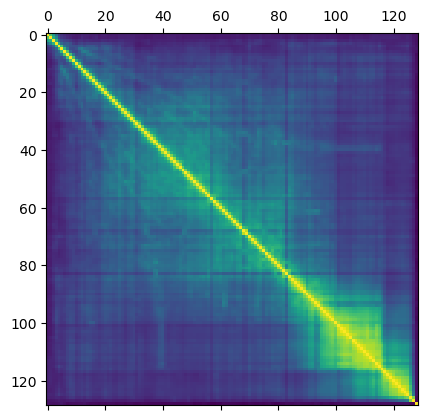

In [41]:
plt.matshow(mel_corr)
plt.show()

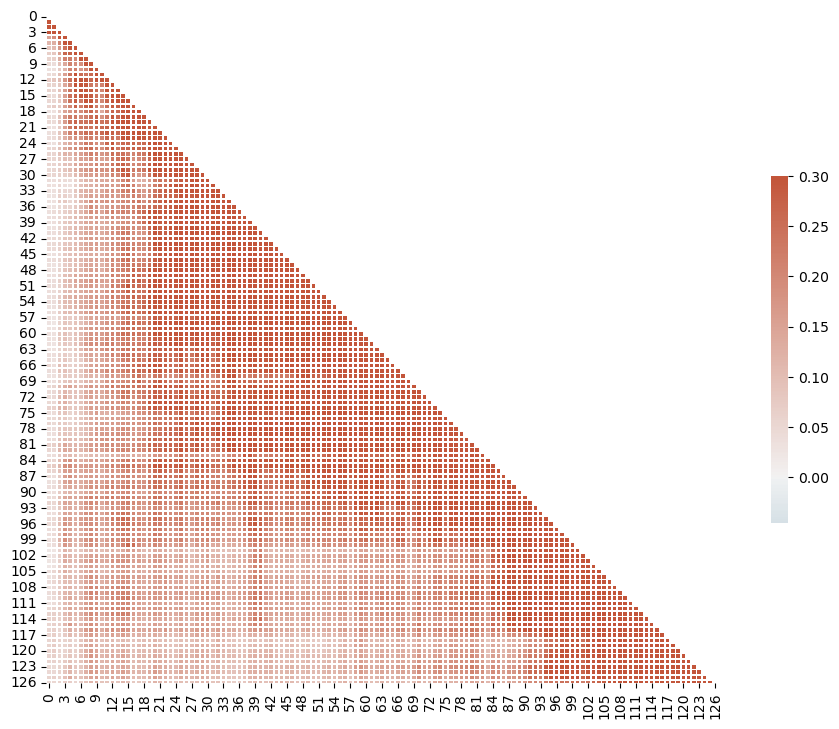

In [55]:
sea_corr_plot(mel_corr)

Looks like there is some feature redundancy here.

The melspectrogram PCA plots suggest, generally speaking, that features are most highly correlated with their neighbor frequencies. Some of the features on the lower end of the spectrum are correlated with a larger neighborhood of features.

In [42]:
def print_high_dv_corr(corr, thresh=0.05):
    # Correlation with output variable
    # features with high correlation to output variable 
    cor_target = abs(corr["emotion_class"]) 
    cor_target.drop('emotion_class', inplace=True)
    print(cor_target[cor_target > thresh])
    
    
print_high_dv_corr(mel_corr, thresh=0.03)

40    0.031815
41    0.032904
51    0.034420
52    0.033816
53    0.031117
56    0.030788
57    0.043406
58    0.046089
59    0.034084
60    0.036169
67    0.031188
68    0.036416
69    0.031435
79    0.034209
80    0.030295
Name: emotion_class, dtype: float64


Unsurprising no single feature correlates strongly to the DV emotion, rather a range of frequencies have weak correlations.

In [47]:
scaled_mel.shape

(9983, 128)

In [48]:
def try_pca(X, scale=False, sig=4, stop_thresh=0.001):
    results = []
    for c in range(1, X.shape[1], 1):
        pca = PCA(n_components=c)
        pca.fit(X)
        evr = pca.explained_variance_ratio_
        min_evr = min(evr)
        results.append([c, round(sum(evr), sig), round(min_evr, sig)])
        if min_evr < stop_thresh: 
            break  
        
    tmp = pd.DataFrame(np.array(results))
    tmp.columns = ['c', 'explain', 'min ft']
    return tmp
        
mel_pca = try_pca(scaled_mel)

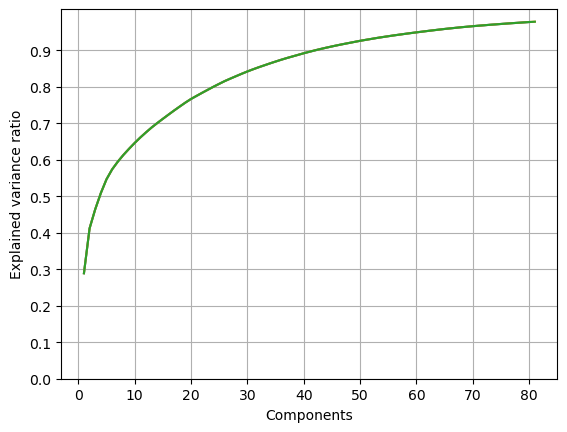

In [50]:
def plot_pca(df, x_step=10):
    plt.plot(df.c.to_numpy(), df.explain.to_numpy())
    plt.grid()
    plt.xlabel("Components")
    plt.ylabel("Explained variance ratio")
    plt.yticks(np.arange(0, 1.0, 0.1))
    plt.xticks(np.arange(0, max(df.c) + 1, x_step))
    plt.show()
    
plot_pca(mel_pca)

35 components explain 80% of the variance, 54 explain 90% and additional features give little from there.

### Explore MFCC

In [56]:
sc_mfcc = scaler.fit_transform(mfcc)
mfcc_df = pd.DataFrame(sc_mfcc)
mfcc_df['emotion_class'] = y_train
mfcc_df.describe()

0             1             2            3             4  \
count  9.983000e+03  9.983000e+03  9.983000e+03  9983.000000  9.983000e+03   
mean  -6.878148e-09 -3.439074e-09  1.528477e-08     0.000000  6.113909e-09   
std    1.000050e+00  1.000050e+00  1.000050e+00     1.000050  1.000050e+00   
min   -5.154975e+00 -6.357793e+00 -4.052638e+00    -5.448266 -5.510037e+00   
25%   -6.150005e-01 -6.216377e-01 -6.388079e-01    -0.631236 -6.130144e-01   
50%    1.623467e-02  6.552821e-02  3.890591e-02     0.013043  2.933373e-02   
75%    6.617097e-01  6.819318e-01  6.813568e-01     0.635530  6.351571e-01   
max    3.883645e+00  3.682312e+00  4.431468e+00     4.658180  4.406283e+00   

                  5             6             7             8             9  \
count  9.983000e+03  9.983000e+03  9.983000e+03  9.983000e+03  9.983000e+03   
mean   1.031722e-08 -4.203313e-09 -1.146358e-09  7.642387e-10  7.642387e-10   
std    1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00   
min   -4.886253e+00 -5.276223e+00 -6.059787e+00 -4.098974e+00 -4.619023e+00   
25%   -6.647649e-01 -6.461762e-01 -6.628618e-01 -6.482063e-01 -6.221534e-01   
50%    7.206649e-03  9.813675e-03 -1.314064e-02 -3.599601e-03  5.404921e-02   
75%    6.601470e-01  6.362651e-01  6.342617e-01  6.578557e-01  6.617709e-01   
max    3.931840e+00  5.488939e+00  4.036853e+00  4.032836e+00  4.387983e+00   

       ...            11            12            13            14  \
count  ...  9.983000e+03  9.983000e+03  9.983000e+03  9.983000e+03   
mean   ...  6.113909e-09  8.406626e-09  2.865895e-09 -1.146358e-09   
std    ...  1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00   
min    ... -5.432119e+00 -4.527724e+00 -5.236336e+00 -7.808297e+00   
25%    ... -6.509012e-01 -6.625004e-01 -6.485454e-01 -6.307023e-01   
50%    ...  4.285770e-03 -1.511344e-02 -3.068633e-02 -1.178242e-02   
75%    ...  6.293022e-01  6.257097e-01  5.998242e-01  5.957571e-01   
max    ...  6.041389e+00  7.699672e+00  6.100499e+00  6.797585e+00   

                 15            16            17            18            19  \
count  9.983000e+03  9.983000e+03  9.983000e+03  9.983000e+03  9.983000e+03   
mean   1.146358e-08 -1.528477e-09  3.056955e-09 -7.642387e-10 -5.731790e-09   
std    1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00   
min   -4.068565e+00 -4.670092e+00 -4.180905e+00 -4.219258e+00 -4.271779e+00   
25%   -6.572497e-01 -6.295765e-01 -6.328379e-01 -6.574505e-01 -6.241565e-01   
50%   -1.665781e-02 -6.056532e-02 -4.660739e-02 -5.654853e-02 -6.793670e-02   
75%    6.251902e-01  5.384698e-01  5.461714e-01  5.698136e-01  5.565798e-01   
max    6.673397e+00  6.806707e+00  7.768197e+00  7.369526e+00  6.070863e+00   

       emotion_class  
count    9980.000000  
mean        3.556313  
std         1.629759  
min         0.000000  
25%         3.000000  
50%         4.000000  
75%         4.000000  
max         6.000000  

[8 rows x 21 columns]

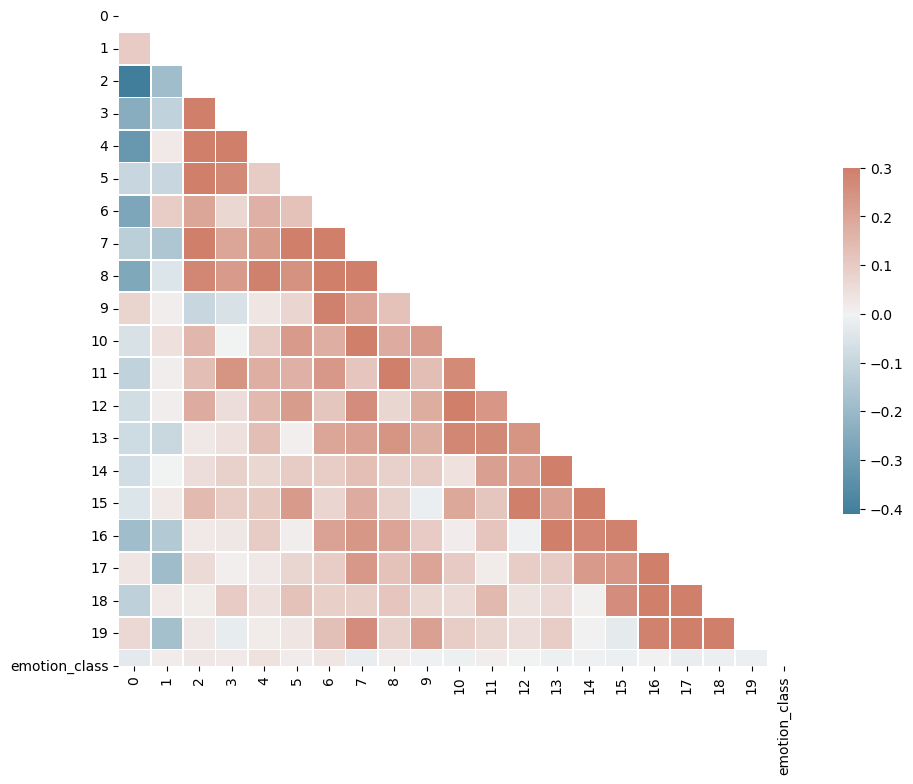

In [57]:
mfcc_corr = mfcc_df.corr()
sea_corr_plot(mfcc_corr)

Some coefficients are correlated, some are not, doesn't seem worth doing a reduction on 20 features.

In [58]:
print_high_dv_corr(mfcc_corr, thresh=0.01)

0     0.032657
1     0.016057
2     0.025779
3     0.019798
4     0.043532
5     0.014312
6     0.032067
7     0.018800
15    0.013110
17    0.018965
18    0.012627
19    0.013721
Name: emotion_class, dtype: float64


Some promise here but generally still weak correlations with DV

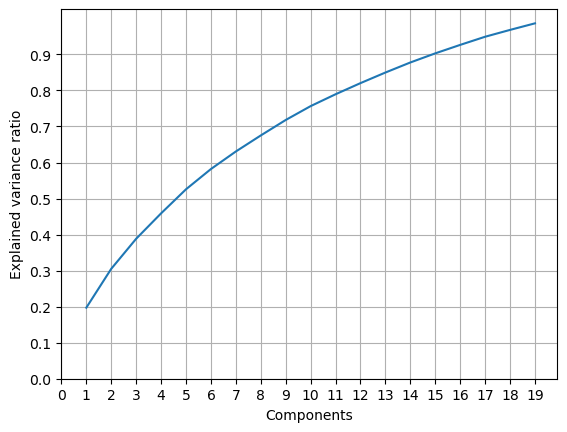

In [60]:
plot_pca(try_pca(sc_mfcc), x_step=1)

Using PCA we can reduce to 11 features and explain 80% or to 15 and get 90%

### Explore Chroma

In [61]:
sc_chroma = scaler.fit_transform(chroma)
chroma_df = pd.DataFrame(sc_chroma)
chroma_df['emotion_class'] = y_train
chroma_df.describe()

0             1             2             3             4  \
count  9.983000e+03  9.983000e+03  9.983000e+03  9.983000e+03  9.983000e+03   
mean  -1.375630e-08 -1.069934e-08 -2.292716e-09  1.528477e-09  1.260994e-08   
std    1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00   
min   -5.481616e+00 -5.061758e+00 -5.236670e+00 -4.990257e+00 -5.358658e+00   
25%   -5.987338e-01 -6.176242e-01 -6.328495e-01 -6.208533e-01 -6.344629e-01   
50%    4.606764e-02  2.678014e-02  3.486827e-02  2.388728e-02  2.476542e-02   
75%    6.364049e-01  6.528607e-01  6.489085e-01  6.589258e-01  6.622157e-01   
max    4.157439e+00  4.013209e+00  4.306844e+00  4.128638e+00  4.349390e+00   

                  5             6             7             8             9  \
count  9.983000e+03  9.983000e+03  9.983000e+03  9.983000e+03  9.983000e+03   
mean  -5.731790e-09 -1.528477e-09 -1.757749e-08  3.821193e-09  6.878148e-09   
std    1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00   
min   -4.761848e+00 -5.302126e+00 -4.952385e+00 -5.002766e+00 -4.830400e+00   
25%   -6.404788e-01 -6.308110e-01 -6.398476e-01 -6.399543e-01 -6.203524e-01   
50%    2.538078e-02  3.610901e-02  4.303931e-02  2.758233e-02  4.695960e-02   
75%    6.683420e-01  6.701922e-01  6.749550e-01  6.809857e-01  6.866525e-01   
max    4.283453e+00  4.141105e+00  3.972467e+00  3.939671e+00  3.793272e+00   

                 10            11  emotion_class  
count  9.983000e+03  9.983000e+03    9980.000000  
mean   1.375630e-08  3.056955e-09       3.556313  
std    1.000050e+00  1.000050e+00       1.629759  
min   -5.594335e+00 -5.755458e+00       0.000000  
25%   -6.204636e-01 -6.140801e-01       3.000000  
50%    4.937265e-02  3.573800e-02       4.000000  
75%    6.691286e-01  6.648781e-01       4.000000  
max    3.632599e+00  4.153077e+00       6.000000

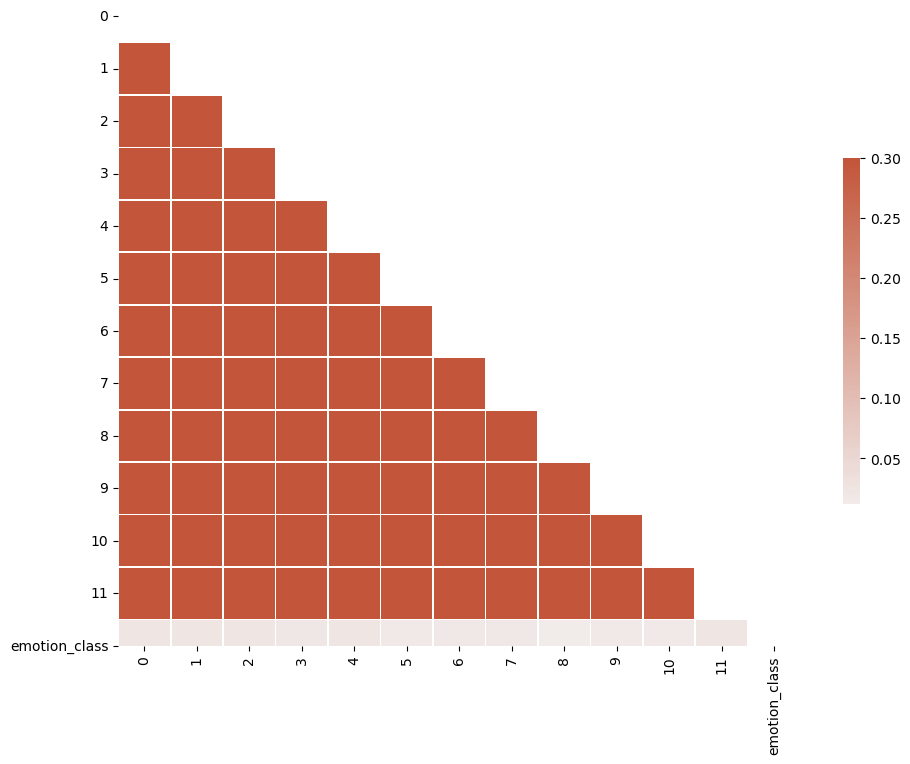

In [62]:
chroma_corr = chroma_df.corr()
sea_corr_plot(chroma_corr)

Looks like the Chroma are highly correlated with each other around 0.3

In [63]:
print_high_dv_corr(chroma_corr, thresh=0.01)

0     0.022456
1     0.024398
2     0.023320
3     0.020040
4     0.024227
5     0.016844
6     0.019202
7     0.018670
8     0.011733
9     0.015326
10    0.017182
11    0.022370
Name: emotion_class, dtype: float64


Each are weakly correlated with the DV

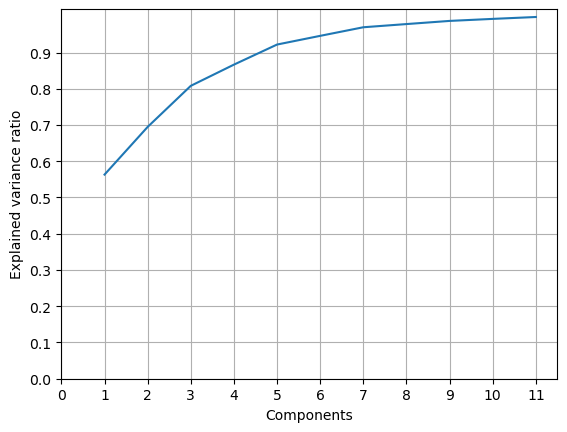

In [64]:
plot_pca(try_pca(sc_chroma), x_step=1)

Five features can explain almost 90% of the data

## EDA Questions

- How many PCA components to use?

- What audio length to use? (fixing starting point at 0 and varying length)

- Metric can be Silhouette Score to measure cluster/category effectiveness. 


In [328]:
def top_2_pca(df):
    pca = PCA(2)
    reduced = pca.fit_transform(df)
    df = pd.DataFrame(reduced)
    df.columns = ['x', 'y']
    df['label'] = np.array(label_encoder.inverse_transform(y_train))
    return df

In [329]:
def pca_scatter(df, label_col='label', emotions=None):
    plt.figure(figsize=(6, 4), dpi=80)
    groups = df.groupby(label_col)
    for name, group in groups:
        if emotions and name not in emotions: 
            continue
        plt.plot(np.array(group.x), np.array(group.y), marker='o', linestyle='', 
                 markersize=2, label=name)

    plt.legend()

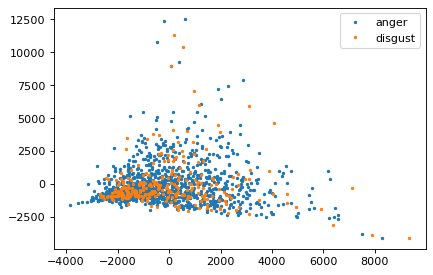

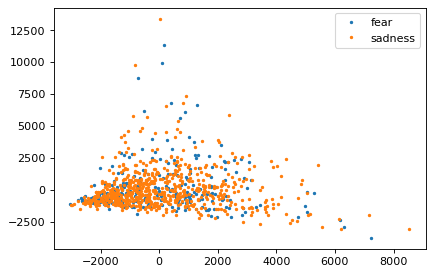

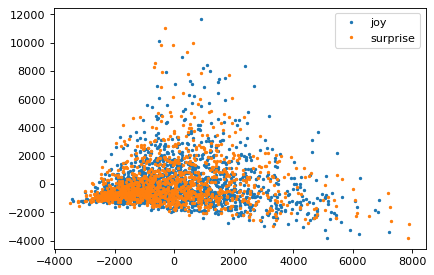

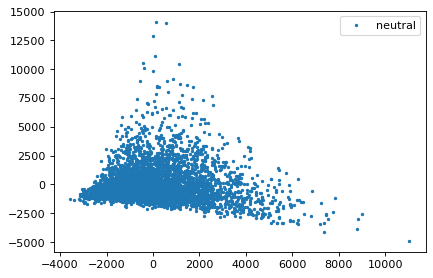

In [330]:
emotions = [('anger', 'disgust'), ('sadness', 'fear'), ('joy', 'surprise'), ('neutral',)]
for emos in emotions:
    pca_scatter(top_2_pca(melspectrogram), emotions={*emos})

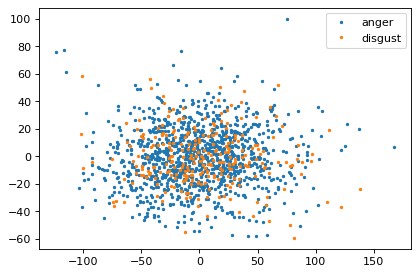

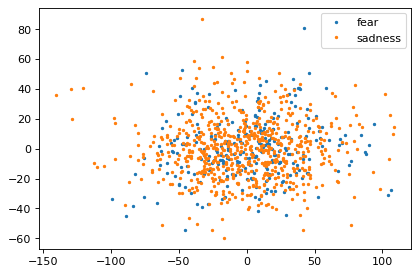

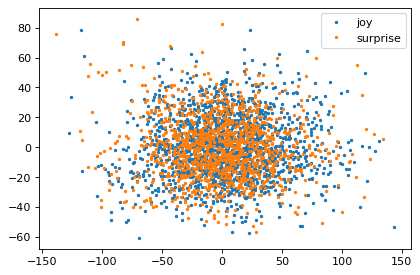

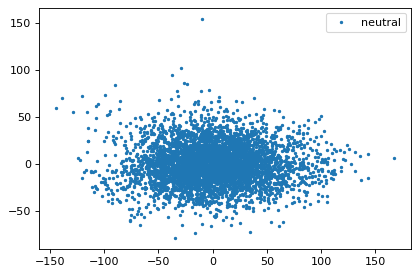

In [271]:
for emotion in emotions:
    pca_scatter(top_2_pca(mfcc), emotions={*emotion})

Visually there are some slight differences for MFCC

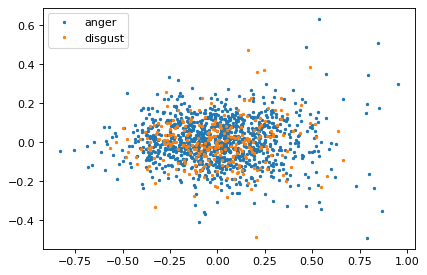

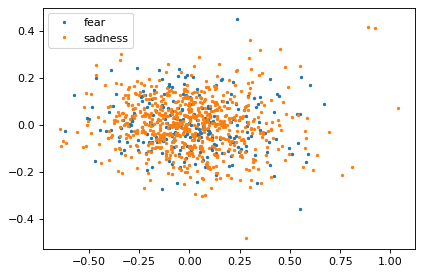

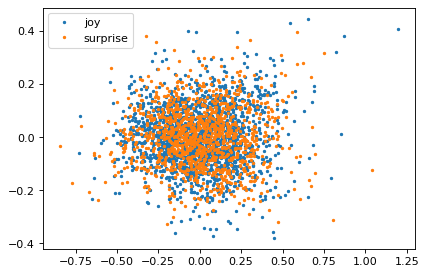

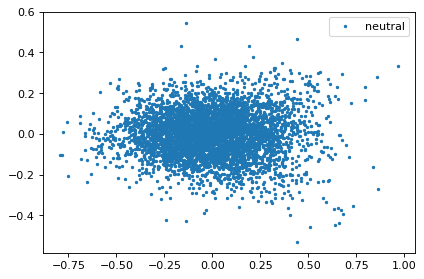

In [272]:
for emotion in emotions:
    pca_scatter(top_2_pca(chroma), emotions={*emotion})

### Assessing Features for Class Separation

#### Baseline

In [9]:
feature_sets = dict(
    mel=melspectrogram,
    mfcc=mfcc,
    chroma=chroma
)
for name, fs in feature_sets.items():
    print(name, silhouette_score(fs, y_train))

mel -0.04264662
mfcc -0.041319244
chroma -0.030214868


The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [77]:
# Compute Silhouette score for various PCA thresholds 
def run_pca(X, c_s, y_train=y_train):
    scores = []
    for c in tqdm_notebook(c_s):
        pca = PCA(n_components=c)
        reduced = pca.fit_transform(X)
        scores.append(silhouette_score(reduced, y_train))   
    return scores

In [ ]:
c_s = list(range(1, melspectrogram.shape[1] // 2, 2))
scores = run_pca(melspectrogram, c_s)

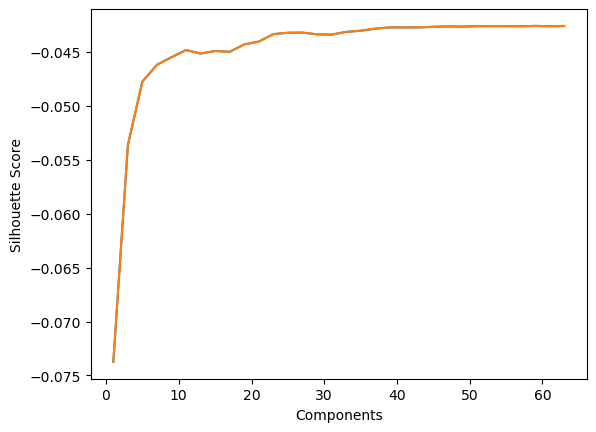

In [68]:
plt.plot(c_s, scores)
plt.xlabel("Components")
plt.ylabel("Silhouette Score")
plt.show()

Mel score peaks at 10-12 components

  0%|          | 0/19 [00:00<?, ?it/s]

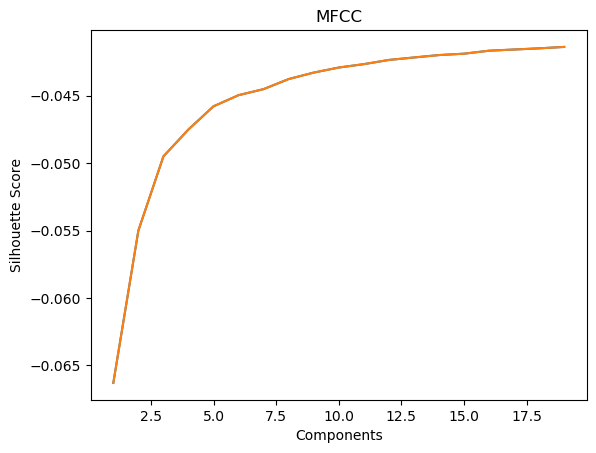

In [71]:
c_s = list(range(1, mfcc.shape[1]))
scores = run_pca(mfcc, c_s)
plt.plot(c_s, scores)
plt.title('MFCC')
plt.xlabel('Components')
plt.ylabel('Silhouette Score')
plt.show();

  0%|          | 0/11 [00:00<?, ?it/s]

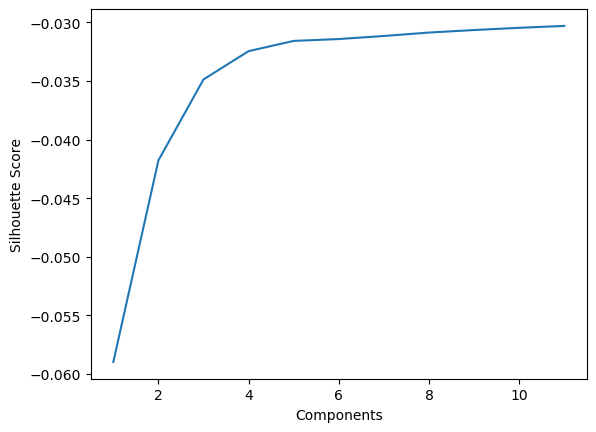

In [72]:
c_s = list(range(1, min(chroma.shape)))
scores = run_pca(chroma, c_s)
plt.plot(c_s, scores)
plt.xlabel("Components")
plt.ylabel("Silhouette Score")
plt.show();



### Effects of truncating audio 



I know the 25% quantile of the audio length is around 35,000, 
 so 75% of the data is longer than this. I can try truncating to 10K, 20K, 30K 
 and assessing performance.

### Defining Pipeline

Naive RandomForest baseline

In [11]:
rf = RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)
print('Train score: ', rf.score(X_train, y_train))
print('Dev score: ', rf.score(X_dev, y_dev))

Train score:  0.9982971050786337
Dev score:  0.42276422764227645


Same as above using Pipeline

In [12]:
pipe = Pipeline(steps=[
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=0))
])

pipe.fit(X_train, y_train)

print('Train score: ', pipe.score(X_train, y_train))
print('Dev score: ', pipe.score(X_dev, y_dev))

Train score:  0.9982971050786337
Dev score:  0.42276422764227645


Now add simple GridSearchCV test over a parameter range

In [13]:
pipe = Pipeline(steps=[
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=0))
])

parameters = {
    'classifier__n_estimators': [50, 100],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [5, 10, 15]
}

search = GridSearchCV(pipe, parameters, cv=2, n_jobs=-1, verbose=3).fit(X_train, y_train)

print('Train score: ', search.score(X_train, y_train))
print('Dev score: ', search.score(X_dev, y_dev))

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Train score:  0.9982971050786337
Dev score:  0.4218608852755194


Plot the score as a function of parameters

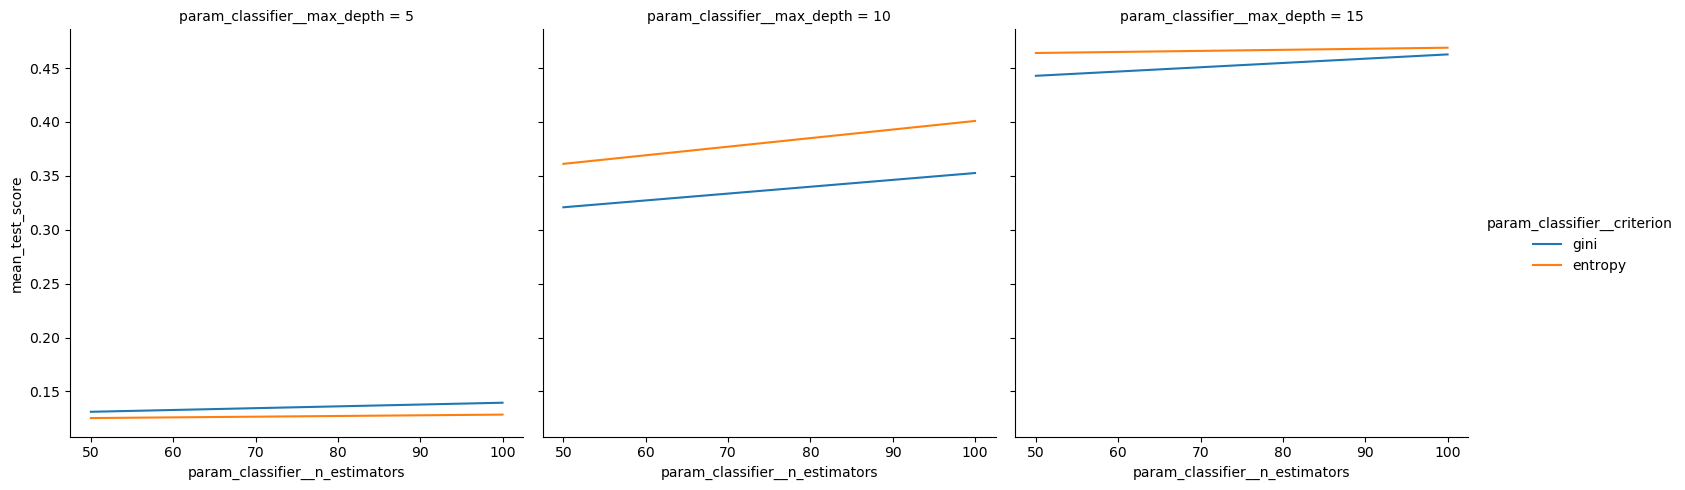

In [15]:
result_df = pd.DataFrame.from_dict(search.cv_results_, orient='columns')
# relational plot
sns.relplot(data=result_df,
            kind='line',
            x='param_classifier__n_estimators',
            y='mean_test_score',
            hue='param_classifier__criterion',  # hue plots range using multiple lines
            col='param_classifier__max_depth'   # plots range using horizontal array of plots
           )
plt.show();

### Experiment: Audio length

Faced this error: https://stackoverflow.com/questions/45335524/custom-sklearn-pipeline-transformer-giving-pickle-picklingerror

Also, I feel it's DRYer to extract classes into their own files. I won't be using Notebooks for everything.

By default Jupyter adds the directory of this notebook to the PYTHONPATH, so I can simply define a package alongside this Notebook and add the ExtractTransformer to it!

In [36]:
print('\n'.join(sys.path))

/Users/home/PycharmProjects/springboard_mle_project/capstone/notebooks
/Users/home/bin/anaconda3/envs/good/lib/python38.zip
/Users/home/bin/anaconda3/envs/good/lib/python3.8
/Users/home/bin/anaconda3/envs/good/lib/python3.8/lib-dynload

/Users/home/bin/anaconda3/envs/good/lib/python3.8/site-packages
/Users/home/bin/anaconda3/envs/good/lib/python3.8/site-packages/IPython/extensions
/Users/home/.ipython


In [ ]:
from framework.transformers import ExtractTransformer

sr = int(train_df.sr.mean())
sample = int(1e20)
X_train_ = X_train[:sample]
y_train_ = y_train[:sample]
         
cachedir = mkdtemp()
steps = [
    ('extractor', ExtractTransformer(sr)),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=0))
]
pipe = Pipeline(steps=steps, memory=cachedir)
parameters = {
    'extractor__limit': [1000 * x for x in range(90, 120, 10)], # ideally to 200K
}
search = GridSearchCV(pipe, parameters, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=3)
search.fit(X_train_, y_train_)  
if os.path.exists(cachedir):
    rmtree(cachedir)

result_df = pd.DataFrame.from_dict(search.cv_results_, orient='columns')
train_score = search.score(X_train_, y_train_)
dev_score = search.score(X_dev, y_dev)
'Train score: ', train_score, 'Dev score: ', dev_score

Last encountered error was cannot find np but I imported it in the module!

In [ ]:
result_df.head()

In [ ]:
sns.relplot(data=result_df,
            kind='line',
            x='param_extractor__limit',
            y='mean_test_score',
           )
plt.show();

Getting a pickle error when Pipeline uses memory cache. If I can't cache the extract results, the CV will be very time consuming. 

so for now, I am going to fall back to my Python impl...

In [50]:
def extract_melspectrogram(result, y, sr):
    feats = np.mean(librosa.feature.melspectrogram(y, sr=sr).T, axis=0)
    return np.hstack((result, feats))


def extract_mfcc(result, y, sr, n_mfcc=20):
    X = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T, axis=0)
    return np.hstack((result, X))


def extract_chroma(result, y, sr):
    stft = np.abs(librosa.stft(y))
    X = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    return np.hstack((result, X))
    

def extract_features(y, sr):
    result = np.array([])
    result = extract_melspectrogram(result, y, sr)
    result = extract_mfcc(result, y, sr)  
    result = extract_chroma(result, y, sr)
    return result


def run_extract(df, audio_limit):
    """Takes df with audio arrays and returns extracted features """
    X_train = []
    start = time()
    for i, r in df.iterrows():
        audio = r.audio if audio_limit is None else r.audio[:audio_limit]
        X_train.append(extract_features(audio, r.sr))
    
    return np.array(X_train)

In [33]:
def eval_with_limit(train_df, validate_df, audio_limit: int):
    X_train_trunc = run_extract(train_df, audio_limit)
    X_dev_trun = run_extract(validate_df, audio_limit)
    
    model = RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1)
    model.fit(X_train_trunc, y_train)
    return model.predict(X_dev_trun)


limit_results = []
for l in list(range(10, 200, 10)):
    limit = l * 1000
    print(limit)
    limit_results.append((limit, eval_with_limit(train_df, dev_df, limit)))


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000


In [35]:
def plot_limit_results(limit_results):
    limits = [x[0] / 22050 for x in limit_results]
    fscores = []
    accuracies = []
    for limit, y_pred in limit_results:
        fscores.append(f1_score(y_dev, y_pred, average='weighted'))
        accuracies.append(accuracy_score(y_dev, y_pred))

    fig, axs = plt.subplots(2)
    axs[0].plot(limits, fscores)
    axs[1].plot(limits, accuracies)
    plt.setp(axs[0], ylabel='f1')
    plt.setp(axs[1], ylabel='accuracy', xlabel='audio limit (seconds)')
    plt.show()

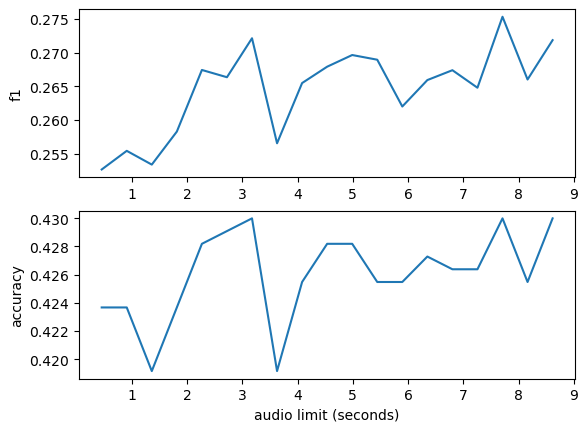

In [36]:
plot_limit_results(limit_results)

The F1 classification score reaches good performace on the first 3 seconds of data. However, the stability of that performance is more stable around 5 seconds. It is only slightly better if all 8+ seconds are used.

Given the sample rate is 22050, I can compute the best known extraction limit (at least for now).

In [54]:
good_extract_limit = 5 * 22050
good_extract_limit

110250

Since I having diffculty with the Feature extraction working, I will simply compute the features for 5s and checkpoint them to disk so that I can move on and experiment.

In [52]:
train_df = train_df.combine_first(pd.DataFrame(run_extract(train_df, good_extract_limit)))
train_df.columns.values

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 'Dialogue_ID', 'Emotion', 'EndTime',
       'Episode', 'Season', 'Sentiment', 'Speaker', 'Sr No.', 'StartTime',
       'Utterance', 'Utterance_ID', 'Utterance_len', 'audio', 'audio_len',
       'dia_utt', 'emotion_class', 'sr'], dtyp

In [56]:
dev_df = dev_df.combine_first(pd.DataFrame(run_extract(dev_df, good_extract_limit)))
dev_df.columns.values

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 'Dialogue_ID', 'Emotion', 'EndTime',
       'Episode', 'Season', 'Sentiment', 'Speaker', 'Sr No.', 'StartTime',
       'Utterance', 'Utterance_ID', 'audio', 'dia_utt', 'emotion_class',
       'sr'], dtype=object)

In [57]:
test_df = test_df.combine_first(pd.DataFrame(run_extract(test_df, good_extract_limit)))
test_df.columns.values

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 'Dialogue_ID', 'Emotion', 'EndTime',
       'Episode', 'Season', 'Sentiment', 'Speaker', 'Sr No.', 'StartTime',
       'Utterance', 'Utterance_ID', 'audio', 'dia_utt', 'emotion_class',
       'sr'], dtype=object)

Before checkpointing, it will be useful to record the extract limit value used to generate the features.

In [55]:
train_df['extract_limit'] = [good_extract_limit] * len(train_df)
dev_df['extract_limit'] = [good_extract_limit] * len(dev_df)
test_df['extract_limit'] = [good_extract_limit] * len(test_df)
train_df.extract_limit

0       110250
1       110250
2       110250
3       110250
4       110250
         ...  
9981    110250
9982    110250
9983    110250
9984    110250
9985    110250
Name: extract_limit, Length: 9983, dtype: int64

In [58]:
checkpoint_dfs()

## Zero rule Classification Baseline


In [62]:
label_counts = train_df['Emotion'].value_counts()
total_labels = label_counts.sum()
correct = max(label_counts)
max_label = label_counts[label_counts == correct].index[0]
accuracy = correct / total_labels * 100
print(f'Always predict "{max_label}" for {accuracy:.2f}% accuracy')

Always predict "neutral" for 47.16% accuracy


### Test the performance on just one person or male/female

In [67]:
results = dict() # store metrics, not functional but keeps DRY

def run_base_rf(df, label:str):
    X_train_ = get_features(df)
    y_train_ = df['emotion_class']
    model = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
    model.fit(X_train_, y_train_)
    y_pred = model.predict(X_test)
    results[label] = classification_report(y_test, y_pred, digits=4, output_dict=True)
    return classification_report(y_test, y_pred, digits=4)


In [71]:
print(train_df.shape)
train_df.dropna(inplace=True)
train_df.shape

(9986, 177)


(9983, 177)

In [72]:
print(run_base_rf(train_df, 'baseline'))
print(results['baseline']['weighted avg']['f1-score'])

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       345
           1     0.0000    0.0000    0.0000        68
           2     0.0000    0.0000    0.0000        50
           3     0.0000    0.0000    0.0000       402
           4     0.4810    0.9984    0.6492      1256
           5     0.0000    0.0000    0.0000       208
           6     1.0000    0.0036    0.0071       281

    accuracy                         0.4808      2610
   macro avg     0.2116    0.1431    0.0938      2610
weighted avg     0.3391    0.4808    0.3132      2610

0.31319301029978674


In [73]:
train_df.Speaker.value_counts()[:10]

Joey        1506
Ross        1458
Rachel      1435
Phoebe      1321
Monica      1299
Chandler    1283
Janice        58
Carol         46
Emily         43
Tag           41
Name: Speaker, dtype: int64

In [74]:
male_speakers = ('Joey', 'Ross', 'Chandler')
male_train = train_df[train_df.Speaker.isin(male_speakers)]
len(male_train)

4247

In [75]:
female_speakers = ('Rachel', 'Phoebe', 'Monica')
female_train = train_df[train_df.Speaker.isin(female_speakers)]
len(female_train)

4055

In [76]:
print(run_base_rf(male_train, label='male'))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       345
           1     0.0000    0.0000    0.0000        68
           2     0.0000    0.0000    0.0000        50
           3     0.2000    0.0025    0.0049       402
           4     0.4812    0.9976    0.6492      1256
           5     0.0000    0.0000    0.0000       208
           6     1.0000    0.0036    0.0071       281

    accuracy                         0.4808      2610
   macro avg     0.2402    0.1434    0.0945      2610
weighted avg     0.3700    0.4808    0.3139      2610



Held-out test perf is nearly the same when training on 3 male speakers vs full train set!

In [77]:
print(run_base_rf(female_train, 'female'))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       345
           1     0.0000    0.0000    0.0000        68
           2     0.0000    0.0000    0.0000        50
           3     0.2000    0.0025    0.0049       402
           4     0.4810    0.9968    0.6489      1256
           5     0.0000    0.0000    0.0000       208
           6     0.0000    0.0000    0.0000       281

    accuracy                         0.4801      2610
   macro avg     0.0973    0.1428    0.0934      2610
weighted avg     0.2623    0.4801    0.3130      2610



Held-out test perf is very slightly worse when training on 3 female speakers vs full train set!

What happens if I just focus training on a single character?

In [81]:
main_characters = male_speakers + female_speakers
for char in main_characters:
    print(char)
    char_train = train_df[train_df.Speaker.isin([char])]
    run_base_rf(char_train, char)
    print(round(results[char]['weighted avg']['f1-score'], 4))

Joey
0.3133
Ross
0.3135
Chandler
0.3141
Rachel
0.315
Phoebe
0.3135
Monica
0.3193


In [82]:
for label, report in sorted(results.items(), reverse=True, 
                            key=lambda x: x[1]['weighted avg']['f1-score']):
    print(label, '\t', round(report['weighted avg']['f1-score'], 4))

Monica 	 0.3193
Rachel 	 0.315
Chandler 	 0.3141
male 	 0.3139
Phoebe 	 0.3135
Ross 	 0.3135
Joey 	 0.3133
baseline 	 0.3132
female 	 0.313


Interestingly the perf is slightly better for Monica, Rachel, and Chandler, perhaps because they are more expressive speakers.

### Cluster measure as a function of Character and PCA components

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

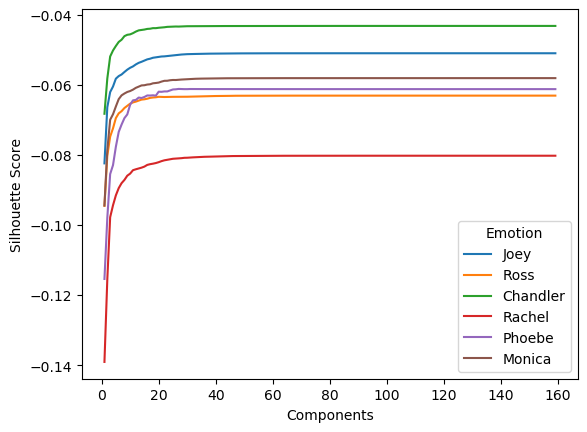

In [78]:
for char in main_characters:
    char_df = train_df[train_df.Speaker == char]
    y_train_ = char_df['emotion_class']
    df = get_features(char_df)
    c_s = list(range(1, 160))
    scores = run_pca(df, c_s, y_train_)
    plt.plot(c_s, scores, label=char)

plt.ylabel('Silhouette Score')
plt.xlabel('Components')
plt.legend(title='Emotion')
plt.show()

Looks like based on the computed features, Chandler is a bit better distinguished, while Rachel is not.

### Revisiting Mel, MFCC, and Chroma

Which feature set leads to the best performance?

In [35]:
melspectrogram.shape, mfcc.shape, chroma.shape

((9983, 128), (9983, 20), (9983, 12))

In [36]:
feature_sets = {'mel': melspectrogram, 'mfcc': mfcc, 'chroma': chroma}
for name, mat in feature_sets.items():
    assert not np.any(np.isnan(mat)), name
    assert np.all(np.isfinite(mat)), name

In [39]:
mel_dev = X_dev[:, :128]
mfcc_dev = X_dev[:, 128: 128 + 20]
chroma_dev = X_dev[:, 128 + 20:]
mel_dev.shape, mfcc_dev.shape, chroma_dev.shape

((1107, 128), (1107, 20), (1107, 12))

In [47]:
names = ('all', 'mel', 'mfcc', 'chroma')
trains = (X_train, melspectrogram, mfcc, chroma)
tests = (X_dev, mel_dev, mfcc_dev, chroma_dev)
for name, X_train_, X_test_ in zip(names, trains, tests):
    model = RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1)
    model.fit(X_train_, y_train)
    y_pred = model.predict(X_test_)
    print(name, '\t', f1_score(y_dev, y_pred, average='weighted'))

all 	 0.2517795844625113
mel 	 0.25156103648343114
mfcc 	 0.2524778784424862
chroma 	 0.2570154031904781


At least on this basic RandomForest model there is a slight ordering:
- Chroma features > mfcc (20 coeffs) > melspectrogram

# Summary

In this notebook I first got a sense of the tabular labeled CSV data. I listened to the outlier short and long utterances which lead me to remove to unintelligle short utterances. I noted that 6 speakers comprise 83% of the data and the presence of a 17x class imbalance b/w fear and neutral and b/w digust and neutral.

I then investigated the following feature extraction methods: Mel-scaled spectrogram,
Mel-frequency cepstral coefficients, Chroma. 
The features produced by these methods are individually weakly correlated with the DV, emotion. Each of the three sets of features can be reduced using PCA and still capture a significant portion of the data's characteristics. This would be especially useful for reducing the 128 melspectrogram features down to ~50 to reduce model complexity.

I determined that PCA should be able to help reduce the number of features. Also that 5 seconds should be enough time to make an accurate judgment of emotion. Training on the males, females, or the entire dataset does not yield much different performance. There are slight performance different when training on single characters, in terms of F1 score on the dev set and the Silhouette Score on the train set, however theses differences do not appear to warrant special treatment.